<a href="https://colab.research.google.com/github/gabbosanti/machine-learning-assignment/blob/main/assignement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CRISP-DM Based Analysis of Second-Half Goal Scoring in Football

This notebook contains all the code of the assignement. The workflow follows the CRISP-DM pattern.

# Business Understanding

# Data Understanding

For the analysis in our system, many free available datasets are available.
Kaggle is one of the most famous online platforms that contains lot of free available dataset.

This dataset is one of the most complete and general-purpouse dataset available, and it's actually composed of :

*   events.csv
*   ginf.csv
*   dictionary.txt

Considering the huge number of events, it's a good idea to store them



In [1]:
import kagglehub
import os, shutil
from pathlib import Path

path = kagglehub.dataset_download("secareanualin/football-events")
print("Kaggle dataset path:", path)

work_dir = Path("data")
work_dir.mkdir(exist_ok=True)

for fname in ["events.csv", "ginf.csv", "dictionary.txt"]:
    shutil.copy(Path(path) / fname, work_dir / fname)

events_path = work_dir / "events.csv"
ginf_path   = work_dir / "ginf.csv"


100%|██████████| 21.1M/21.1M [00:00<00:00, 74.2MB/s]

Extracting files...


Kaggle dataset path: /root/.cache/kagglehub/datasets/secareanualin/football-events/versions/1


Stores the datasets in a Pandas dataframe.

In [2]:
import pandas as pd

events_df = pd.read_csv(events_path)
ginf_df   = pd.read_csv(ginf_path)


### Data Profiling

Once we collect our data, it's important to describe their statistics

In [5]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941009 entries, 0 to 941008
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id_odsp        941009 non-null  object 
 1   id_event       941009 non-null  object 
 2   sort_order     941009 non-null  int64  
 3   time           941009 non-null  int64  
 4   text           941009 non-null  object 
 5   event_type     941009 non-null  int64  
 6   event_type2    214293 non-null  float64
 7   side           941009 non-null  int64  
 8   event_team     941009 non-null  object 
 9   opponent       941009 non-null  object 
 10  player         880009 non-null  object 
 11  player2        291310 non-null  object 
 12  player_in      51715 non-null   object 
 13  player_out     51738 non-null   object 
 14  shot_place     227459 non-null  float64
 15  shot_outcome   228498 non-null  float64
 16  is_goal        941009 non-null  int64  
 17  location       467067 non-nul

In [9]:
events_df.describe(include="all")

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
count,941009,941009,941009.000000,941009.000000,941009,941009.000000,214293.000000,941009.000000,941009,941009,...,51715,51738,227459.000000,228498.000000,941009.000000,467067.000000,229185.000000,941009.000000,229137.000000,941009.000000
unique,9074,941009,NaN,NaN,366076,NaN,NaN,NaN,142,142,...,5093,4671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ITbfCc8F/,z5L2OT5E127,NaN,NaN,Foul by Perparim Hetemaj (Chievo).,NaN,NaN,NaN,Juventus,Genoa,...,adrian,gonzalo castro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,180,1,NaN,NaN,396,NaN,NaN,NaN,12054,11981,...,147,103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,53.858826,49.663663,NaN,4.326575,12.233764,1.481170,NaN,NaN,...,NaN,NaN,5.733693,1.926555,0.025978,6.209073,1.624831,0.264332,1.281316,0.004876
std,NaN,NaN,32.014268,26.488977,NaN,2.995313,0.468850,0.499646,NaN,NaN,...,NaN,NaN,3.326100,0.797055,0.159071,5.421736,0.740400,0.655501,0.709394,0.069655
min,NaN,NaN,1.000000,0.000000,NaN,1.000000,12.000000,1.000000,NaN,NaN,...,NaN,NaN,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,NaN,NaN,27.000000,27.000000,NaN,2.000000,12.000000,1.000000,NaN,NaN,...,NaN,NaN,2.000000,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000
50%,NaN,NaN,53.000000,51.000000,NaN,3.000000,12.000000,1.000000,NaN,NaN,...,NaN,NaN,5.000000,2.000000,0.000000,3.000000,1.000000,0.000000,1.000000,0.000000
75%,NaN,NaN,79.000000,73.000000,NaN,8.000000,12.000000,2.000000,NaN,NaN,...,NaN,NaN,9.000000,3.000000,0.000000,11.000000,2.000000,0.000000,1.000000,0.000000


In [6]:
ginf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10112 entries, 0 to 10111
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id_odsp    10112 non-null  object 
 1   link_odsp  10112 non-null  object 
 2   adv_stats  10112 non-null  bool   
 3   date       10112 non-null  object 
 4   league     10112 non-null  object 
 5   season     10112 non-null  int64  
 6   country    10112 non-null  object 
 7   ht         10112 non-null  object 
 8   at         10112 non-null  object 
 9   fthg       10112 non-null  int64  
 10  ftag       10112 non-null  int64  
 11  odd_h      10112 non-null  float64
 12  odd_d      10112 non-null  float64
 13  odd_a      10112 non-null  float64
 14  odd_over   977 non-null    float64
 15  odd_under  977 non-null    float64
 16  odd_bts    977 non-null    float64
 17  odd_bts_n  977 non-null    float64
dtypes: bool(1), float64(7), int64(3), object(7)
memory usage: 1.3+ MB


In [10]:
ginf_df.describe(include="all")

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
count,10112,10112,10112,10112,10112,10112.000000,10112,10112,10112,10112.000000,10112.000000,10112.000000,10112.000000,10112.000000,977.000000,977.000000,977.000000,977.000000
unique,10112,10112,2,967,5,NaN,5,147,148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,fodCw2I2/,/soccer/spain/laliga/ath-bilbao-atl-madrid-fod...,True,2012-05-13,E0,NaN,england,Nice,Liverpool,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,9182,38,2120,NaN,2120,106,107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,2014.290249,NaN,NaN,NaN,1.548062,1.154964,2.930120,4.278434,5.537545,2.046817,2.105629,1.942917,2.063941
std,NaN,NaN,NaN,NaN,NaN,1.610074,NaN,NaN,NaN,1.309591,1.142596,2.370135,1.863643,5.700485,0.367062,0.536646,0.211102,0.251276
min,NaN,NaN,NaN,NaN,NaN,2012.000000,NaN,NaN,NaN,0.000000,0.000000,1.060000,1.910000,1.110000,1.140000,1.420000,1.410000,1.440000
25%,NaN,NaN,NaN,NaN,NaN,2013.000000,NaN,NaN,NaN,1.000000,0.000000,1.760000,3.430000,2.740000,1.790000,1.780000,1.800000,1.870000
50%,NaN,NaN,NaN,NaN,NaN,2014.000000,NaN,NaN,NaN,1.000000,1.000000,2.270000,3.680000,3.860000,2.030000,1.970000,1.920000,2.050000
75%,NaN,NaN,NaN,NaN,NaN,2016.000000,NaN,NaN,NaN,2.000000,2.000000,3.080000,4.300000,6.000000,2.280000,2.270000,2.050000,2.200000


Visualizing the data

# Data Preparation



In [11]:
def create_dataset():

    # Reduce events_df dataset, filtering only first-half events
    first_half_events = events_df[events_df['time'] <= 45].copy()

    # Creating new features
    first_half_events['shot_on_target'] = (
      (first_half_events['event_type'] == 1) &
      (first_half_events['shot_outcome'] == 1)
    )

    first_half_events['shot_off_target'] = (
      (first_half_events['event_type'] == 1) &
      (first_half_events['shot_outcome'] == 2)
    ).astype(int)

    first_half_events['corner'] = (first_half_events['event_type'] == 2).astype(int)
    first_half_events['free_kick'] = (first_half_events['event_type'] == 8).astype(int)
    first_half_events['offside'] = (first_half_events['event_type'] == 9).astype(int)
    first_half_events['foul'] = (first_half_events['event_type'] == 3).astype(int)
    first_half_events['yellow_card'] = (first_half_events['event_type'] == 4).astype(int)
    first_half_events['goal'] = first_half_events['is_goal'].astype(int)

    # Aggregation : calculating how many occurences of every event
    matches_features = (first_half_events.groupby(['id_odsp', 'side'] , as_index=False).agg({
            'shot_on_target': 'sum',
            'shot_off_target': 'sum',
            'corner': 'sum',
            'free_kick': 'sum',
            'offside': 'sum',
            'foul': 'sum',
            'yellow_card': 'sum',
            'goal': 'sum'
        })
    )

    #Split between home and away
    home = matches_features[matches_features['side'] == 1].drop(columns='side').add_suffix('_home')
    away = matches_features[matches_features['side'] == 2].drop(columns='side').add_suffix('_away')

    #Renaming columns for merging
    home = home.rename(columns={'id_odsp_home': 'id_odsp'})
    away = away.rename(columns={'id_odsp_away': 'id_odsp'})

    #Merging to ginf_ds
    dataset = (
        ginf_df[['id_odsp', 'fthg']]
        .merge(home, on='id_odsp', how='left')
        .merge(away, on='id_odsp', how='left')
    )

    dataset['home_scored_second_half'] = (
        (dataset['fthg'] - dataset['goal_home']) > 0
    ).astype(int)

    dataset = dataset.drop(columns=['fthg'])
    return pd.DataFrame(dataset)


In [13]:
df = create_dataset()
df

,id_odsp,shot_on_target_home,shot_off_target_home,corner_home,free_kick_home,offside_home,foul_home,yellow_card_home,goal_home,shot_on_target_away,shot_off_target_away,corner_away,free_kick_away,offside_away,foul_away,yellow_card_away,goal_away,home_scored_second_half
0,UFot0hit/,3.0,5.0,4.0,5.0,1.0,5.0,0.0,2.0,0.0,2.0,2.0,5.0,0.0,6.0,1.0,0.0,1
1,Aw5DflLH/,3.0,3.0,2.0,15.0,0.0,8.0,2.0,0.0,1.0,1.0,2.0,9.0,0.0,15.0,1.0,0.0,1
2,bkjpaC6n/,2.0,2.0,2.0,15.0,3.0,5.0,0.0,0.0,1.0,0.0,2.0,7.0,4.0,15.0,1.0,0.0,1
3,CzPV312a/,0.0,3.0,2.0,5.0,3.0,10.0,1.0,0.0,2.0,1.0,2.0,11.0,4.0,4.0,1.0,1.0,0
4,GUOdmtII/,1.0,5.0,1.0,6.0,1.0,6.0,0.0,1.0,4.0,3.0,5.0,6.0,1.0,6.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10107,xAkY8l6R/,1.0,0.0,2.0,3.0,3.0,9.0,0.0,1.0,2.0,2.0,5.0,9.0,1.0,3.0,1.0,0.0,1
10108,xSU9scI9/,2.0,1.0,7.0,7.0,1.0,6.0,1.0,1.0,2.0,1.0,2.0,6.0,0.0,7.0,2.0,0.0,1
10109,xY7uZwOI/,6.0,5.0,3.0,7.0,2.0,4.0,0.0,3.0,0.0,0.0,1.0,4.0,0.0,7.0,1.0,0.0,1
10110,YyeGxMX8/,3.0,4.0,6.0,6.0,4.0,4.0,0.0,0.0,1.0,2.0,4.0,4.0,1.0,5.0,1.0,0.0,0


# Modeling

In [18]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X = df.drop(["home_scored_second_half", "id_odsp"], axis="columns")
y = df["home_scored_second_half"]

seed=42 #
test_size=0.20 # 20% of the dataset is for test, remaining 80% for training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (8089, 16)
y_train: (8089,)
X_test: (2023, 16)
y_test: (2023,)


Let's test a simple decision tree

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(max_depth=10, random_state=seed)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5921898171033119


Print the tree

[Text(0.6306109725685786, 0.9545454545454546, 'yellow_card_home <= 4.5\ngini = 0.5\nsamples = 8089\nvalue = [4022, 4067]'),
 Text(0.6281172069825436, 0.8636363636363636, 'shot_on_target_home <= 3.5\ngini = 0.492\nsamples = 7241\nvalue = [3174, 4067]'),
 Text(0.629364089775561, 0.9090909090909092, 'True  '),
 Text(0.3914432668329177, 0.7727272727272727, 'shot_off_target_home <= 4.5\ngini = 0.497\nsamples = 5908\nvalue = [2722, 3186]'),
 Text(0.22194513715710723, 0.6818181818181818, 'offside_home <= 1.5\ngini = 0.499\nsamples = 5136\nvalue = [2429, 2707]'),
 Text(0.1206359102244389, 0.5909090909090909, 'shot_off_target_away <= 0.5\ngini = 0.5\nsamples = 3351\nvalue = [1650, 1701]'),
 Text(0.06514962593516209, 0.5, 'shot_on_target_away <= 0.5\ngini = 0.481\nsamples = 402\nvalue = [162.0, 240.0]'),
 Text(0.038029925187032416, 0.4090909090909091, 'free_kick_home <= 6.5\ngini = 0.402\nsamples = 86\nvalue = [24.0, 62.0]'),
 Text(0.0199501246882793, 0.3181818181818182, 'offside_home <= 0.5\ngi

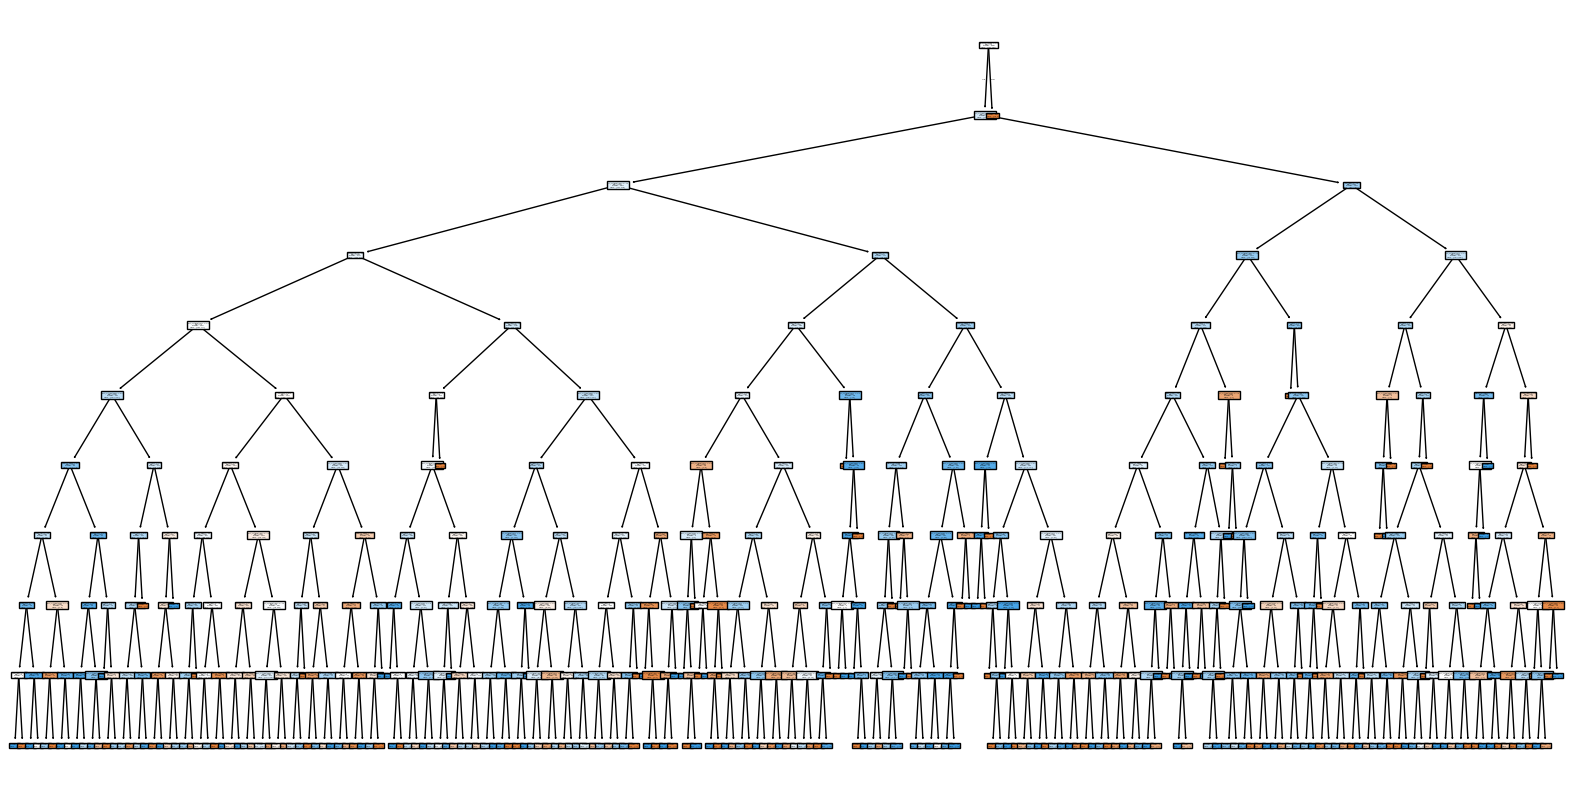

In [24]:
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
#plot_tree(clf, filled=True, feature_names=X.columns)